In [21]:
from sklearn.dummy import DummyClassifier
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from typing import Type
from torch.optim import lr_scheduler
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,CrossEntropyLoss,Conv2d,MaxPool2d
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
import sys
import random
import copy
import time
from time import strftime, localtime
import shutil
import pickle
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
from pandas import DataFrame
import seaborn as sn
import numpy as np
import pandas as pd
import PIL
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
from ipynb.fs.full._3_prepare_tracked_datasets import Char,Poly,Point,CustomUnpickler
from ipynb.fs.full._9_rus_fft_angles import FNNCell,CNNCell

0
None
0
None
0


/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Классов: 76
None


In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
TRACK_MAX_LEN=30
SHIFT_STEP=10
CURRENT_FOLDER="./"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data prepare

In [5]:
DATASET='russian_extra'# russian, russian_extra, uji
f_train_dict= open(os.path.join(CURRENT_FOLDER,'train_dict_extra.p'), 'rb')
f_test_dict= open(os.path.join(CURRENT_FOLDER,'test_dict_extra.p'), 'rb')
TRAIN_DICT = CustomUnpickler(f_train_dict).load()
TEST_DICT = CustomUnpickler(f_test_dict).load()
f_train_dict.close()
f_test_dict.close()

In [6]:
# print(TRAIN_DICT)
# print(TEST_DICT)
CHAR_LIST=list(TRAIN_DICT.keys())
CHAR_LIST.sort()
print(len(list(TRAIN_DICT.keys())))
print(list(TRAIN_DICT.keys()).sort())
print(len(list(TEST_DICT.keys())))
print(list(TEST_DICT.keys()).sort())
all_size=0
for key in TRAIN_DICT.keys():
    all_size+=len(TRAIN_DICT[key])
print(all_size)
all_size=0
for key in TEST_DICT.keys():
    all_size+=len(TEST_DICT[key])
print(all_size)

114
None
57
None
261
72


# NN prepare

In [7]:
# i=0
# module_list =[module for module in net.modules()]
# for count,val in enumerate(module_list):
#     print(i,count,val)
#     i+=1

In [8]:
NUM_CLASSES=76
DATASET_VARIANT="byclass"
net_fnn=FNNCell(track_max_len=TRACK_MAX_LEN,num_classes=NUM_CLASSES).to(device)
net_fnn.load_state_dict(torch.load("models/rus_fft_fcnet_"+DATASET_VARIANT+".pt"))        

<All keys matched successfully>

In [9]:
NUM_CLASSES=76
DATASET_VARIANT="byclass"
net_cnn=CNNCell(num_classes=NUM_CLASSES).to(device)
net_cnn.load_state_dict(torch.load("models/rus_fft_cnnnet_"+DATASET_VARIANT+".pt"))
net_cnn.eval()

CNNCell(
  (layers): ModuleList(
    (0): ModuleList(
      (0): Conv1d(1, 20, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.05, inplace=False)
      (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(20, 30, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.05, inplace=False)
      (4): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(30, 40, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.05, inplace=False)
      (4): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
 

In [10]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x

In [11]:
net_fnn.fc1=Identity()
net_cnn.fc1=Identity()

# Process

In [12]:
# len(TRAIN_DICT["cъешь_w_0"][1].singlePolys().angles)

In [13]:
WORDS=set()
for k in TRAIN_DICT.keys():
    WORDS.add(k.split("_")[0])
len(WORDS),WORDS

(9,
 {'cъешь',
  'булок',
  'выпей',
  'да',
  'ещё',
  'мягких',
  'французских',
  'чаю',
  'этих'})

In [14]:
WORDS=list(WORDS)

In [15]:
TRAIN_DICT_=dict()
for w in WORDS:
    if not w in TRAIN_DICT_:
        TRAIN_DICT_[w]=list()
    for k_trn in TRAIN_DICT.keys():
        if not k_trn.startswith(w): continue    
        TRAIN_DICT_[w]+=[c for c in TRAIN_DICT[k_trn]] 
TEST_DICT_=dict()
for w in WORDS:
    if not w in TEST_DICT_:
        TEST_DICT_[w]=list()
    for k_tst in TEST_DICT.keys():
        if not k_tst.startswith(w): continue    
        TEST_DICT_[w]+=[c for c in TEST_DICT[k_tst]] 

In [23]:
cos = torch.nn.CosineSimilarity(dim=1)

def calcFFT(ch,net,device,track_max_len=TRACK_MAX_LEN):
    yf = rfft(ch)
    F = np.abs(yf)[:track_max_len]
    F=torch.Tensor(F)
    vec=net(F[None,:].to(device))
    return vec

def compare_word(ch1,ch2,net,device,track_max_len=TRACK_MAX_LEN,shift_step=SHIFT_STEP):
    # pass
    L=200
    N1=(len(ch1.singlePolys().angles)-L)//shift_step
    N2=(len(ch2.singlePolys().angles)-L)//shift_step
    N1=max(1,N1)
    N2=max(1,N2)
    sim_avg=0
    sim_num=0
    for i in range(N1):
        C1=ch1.singlePolys().angles[i*shift_step:i*shift_step+L]
        vec1=calcFFT(C1,net,device,track_max_len)
        sim_max=0
        for j in range(N2):
            C2=ch2.singlePolys().angles[j*shift_step:j*shift_step+L]
            vec2=calcFFT(C2,net,device,track_max_len)
            sim = cos(vec1, vec2)
            sim_max = max(float(sim),sim_max)
        sim_avg+=sim_max
        sim_num+=1
    sim_avg = 0 if sim_num==0 else sim_avg/sim_num
    return sim_avg

def process_all_words(net,device,track_max_len=TRACK_MAX_LEN,shift_step=SHIFT_STEP,words=WORDS):
    df=DataFrame()  
    combination=1
    start_time = time.time()    
    for w in words:   
        for tst in TEST_DICT_[w]:
            # print(k_tst)
            for trn in TRAIN_DICT_[w]:
                # print("  "+k_trn)
                similarity=compare_word(tst,trn,net,device,track_max_len,shift_step)
                # if similarity>0.8: print(similarity,tst,trn)
                new_row = {'Author1':str(tst).split("_")[2], 'Author2':str(trn).split("_")[2], 
                           'Similarity':similarity, 'Word':w,
                           'One':1 if str(tst).split("_")[2]==str(trn).split("_")[2] else 0}
                df = pd.concat([df, pd.DataFrame.from_records([new_row])])
                clear_output(True)
                t=(time.time()-start_time)/combination
                future_time=strftime('%Y-%m-%d %H:%M:%S', localtime(time.time()+(2053-combination)*t))
                print("N {}/2053  ({} sec/ph, arrival {}) -- Authors:({},{}) Similarity: {}".format(combination,round(t,1),future_time,str(tst).split("_")[2],str(trn).split("_")[2],similarity))
                # print("  {} {} {}".format(str(tst).split("_")[2],str(trn).split("_")[2],similarity))
                # print("======")
                combination+=1
    print(combination)
    return df

In [24]:
df_cnn=process_all_words(net_cnn,device,track_max_len=TRACK_MAX_LEN,shift_step=SHIFT_STEP,words=WORDS)
df_cnn.to_excel('graphology_dataCNN.xlsx')
df_cnn = pd.read_excel('graphology_dataCNN.xlsx', index_col=0)

N 2052/232  (0.6 sec/ph, arrival 2023-07-28 20:14:53) -- Authors:(5,10) Similarity: 0.6129918018976848
2053


In [25]:
df_fnn=process_all_words(net_fnn,device,track_max_len=TRACK_MAX_LEN,shift_step=SHIFT_STEP,words=WORDS)
df_fnn.to_excel('graphology_dataFNN.xlsx')
df_fnn = pd.read_excel('graphology_dataFNN.xlsx', index_col=0)

N 2052/232  (0.4 sec/ph, arrival 2023-07-28 20:35:16) -- Authors:(5,10) Similarity: 0.5852872848510742
2053


# Analyze

# FNN

In [46]:
df = pd.read_excel('graphology_dataFNN.xlsx', index_col=0)

In [47]:
df_1=df.loc[df.One == 1]
df_0=df.loc[df.One == 0]

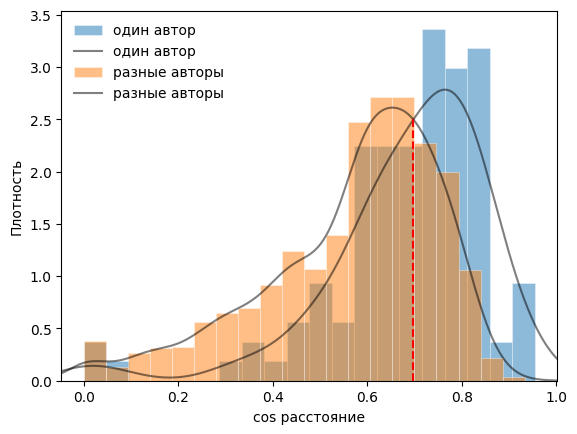

In [48]:
ax = df_1['Similarity'].plot.hist(bins=20, density=True, edgecolor='w', linewidth=0.5,alpha=0.5)
xlim = ax.get_xlim()
ax=df_1['Similarity'].plot.density(color='k', alpha=0.5, ax=ax)
df_0['Similarity'].plot.hist(bins=20, density=True, edgecolor='w', ax=ax, linewidth=0.5, alpha=0.5)
df_0['Similarity'].plot.density(color='k', alpha=0.5, ax=ax) 
ax.legend(["один автор","один автор","разные авторы","разные авторы"],frameon=False)
ax.plot([0.696,0.696],[0,2.51],color="r", linestyle='dashed')
ax.set_xlim(xlim)
plt.ylabel("Плотность")
plt.xlabel("cos расстояние")
plt.savefig("images/authors_words_fnn_disp.png",  bbox_inches='tight', pad_inches=0)
plt.show()

In [49]:
cm=np.zeros((2,2),dtype="int")
cm[0,0]=len(df_0.loc[(df_0.Similarity < 0.696)])
cm[0,1]=len(df_0.loc[(df_0.Similarity >= 0.696)])
cm[1,0]=len(df_1.loc[(df_1.Similarity < 0.696)])
cm[1,1]=len(df_1.loc[(df_1.Similarity >= 0.696)])
print(cm)

[[1415  525]
 [  49   63]]


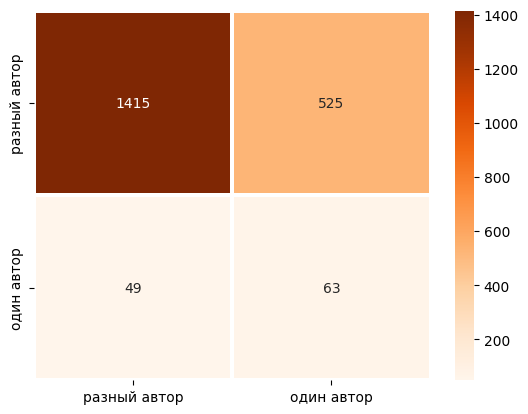

In [50]:
df_cm = DataFrame(cm, index=["разный автор","один автор"], columns=["разный автор","один автор"])
sn.heatmap(df_cm,annot=True, fmt="d",linewidths=1.5,cmap="Oranges",)
plt.savefig("images/authors_words_fnn_confusion_matrix.png",  bbox_inches='tight', pad_inches=0)
plt.show()

In [51]:
TP = 63
TN = 1415
FP = 49
FN = 525
N=TP+TN+FP+FN
Accuracy=(TP+TN)/N    # общая точность
Precision=TP/(TP+FP)  # точность 
Recall=TP/(TP+FN)     # полнота
F1=2*Precision*Recall/(Precision+Recall)   # F1 мера
Sensitivity= TP / (TP + FN)
Specificity =TN / (TN + FP)
BalancedAccuracy=(Sensitivity+Specificity)/2
print("Accuracy: {}".format(Accuracy))
print("Precision: {}".format(Precision))
print("Recall: {}".format(Recall))
print("F1: {}".format(F1))
print("BalancedAccuracy: {}".format(BalancedAccuracy))

Accuracy: 0.7202729044834308
Precision: 0.5625
Recall: 0.10714285714285714
F1: 0.18
BalancedAccuracy: 0.536836455893833


In [52]:
cm=np.zeros((9,2),dtype="int")
cm[0,0]=len(df_1.loc[(df_1.Similarity >= 0.696) & (df_1.Word == 'cъешь')])
cm[0,1]=len(df_1.loc[(df_1.Similarity < 0.696) & (df_1.Word == 'cъешь')])
cm[1,0]=len(df_1.loc[(df_1.Similarity >= 0.696) & (df_1.Word == 'ещё')])
cm[1,1]=len(df_1.loc[(df_1.Similarity < 0.696) & (df_1.Word == 'ещё')])
cm[2,0]=len(df_1.loc[(df_1.Similarity >= 0.696) & (df_1.Word == 'этих')])
cm[2,1]=len(df_1.loc[(df_1.Similarity < 0.696) & (df_1.Word == 'этих')])
cm[3,0]=len(df_1.loc[(df_1.Similarity >= 0.696) & (df_1.Word == 'мягких')])
cm[3,1]=len(df_1.loc[(df_1.Similarity < 0.696) & (df_1.Word == 'мягких')])
cm[4,0]=len(df_1.loc[(df_1.Similarity >= 0.696) & (df_1.Word == 'французских')])
cm[4,1]=len(df_1.loc[(df_1.Similarity < 0.696) & (df_1.Word == 'французских')])
cm[5,0]=len(df_1.loc[(df_1.Similarity >= 0.696) & (df_1.Word == 'булок')])
cm[5,1]=len(df_1.loc[(df_1.Similarity < 0.696) & (df_1.Word == 'булок')])
cm[6,0]=len(df_1.loc[(df_1.Similarity >= 0.696) & (df_1.Word == 'да')])
cm[6,1]=len(df_1.loc[(df_1.Similarity < 0.696) & (df_1.Word == 'да')])
cm[7,0]=len(df_1.loc[(df_1.Similarity >= 0.696) & (df_1.Word == 'выпей')])
cm[7,1]=len(df_1.loc[(df_1.Similarity < 0.696) & (df_1.Word == 'выпей')])
cm[8,0]=len(df_1.loc[(df_1.Similarity >= 0.696) & (df_1.Word == 'чаю')])
cm[8,1]=len(df_1.loc[(df_1.Similarity < 0.696) & (df_1.Word == 'чаю')])
print(cm)

[[12  4]
 [ 4  8]
 [ 8  5]
 [ 9  7]
 [10  1]
 [ 2  7]
 [ 2  9]
 [ 7  6]
 [ 9  2]]


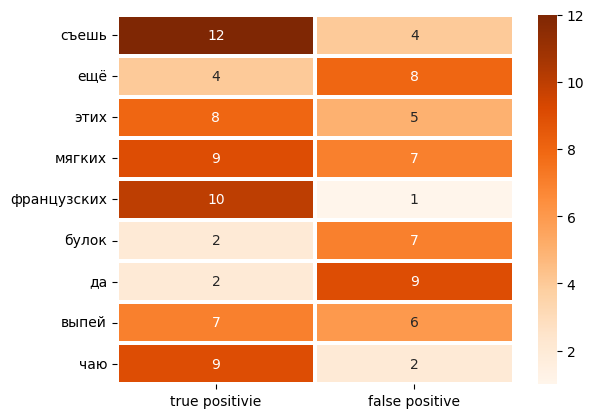

In [53]:
df_cm = DataFrame(cm, index=['cъешь','ещё','этих','мягких','французских','булок','да','выпей', 'чаю'],
        columns=["true positivie","false positive"])
# plt.subplots(figsize=(20,20))
sn.heatmap(df_cm,annot=True, fmt="d",linewidths=1.5,cmap="Oranges",)
plt.savefig("images/authors_words_long_fnn_confusion_matrix.png",  bbox_inches='tight', pad_inches=0)
plt.show()

# CNN

In [54]:
df = pd.read_excel('graphology_dataCNN.xlsx', index_col=0)

In [55]:
df_1=df.loc[df.One == 1]
df_0=df.loc[df.One == 0]

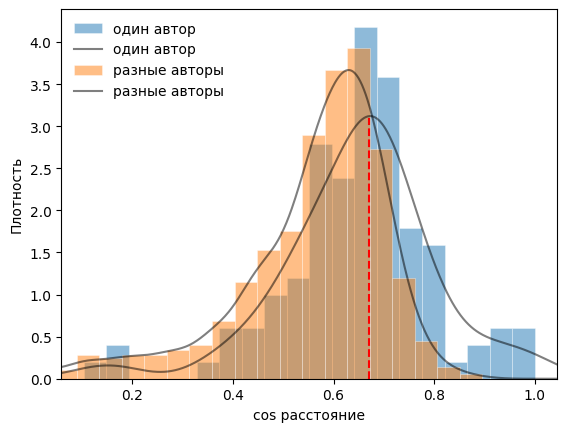

In [56]:
ax = df_1['Similarity'].plot.hist(bins=20, density=True, edgecolor='w', linewidth=0.5,alpha=0.5)
xlim = ax.get_xlim()
ax=df_1['Similarity'].plot.density(color='k', alpha=0.5, ax=ax)
df_0['Similarity'].plot.hist(bins=20, density=True, edgecolor='w', ax=ax, linewidth=0.5, alpha=0.5)
df_0['Similarity'].plot.density(color='k', alpha=0.5, ax=ax) 
ax.legend(["один автор","один автор","разные авторы","разные авторы"],frameon=False)
ax.plot([0.67,0.67],[0,3.1],color="r", linestyle='dashed')
ax.set_xlim(xlim)
plt.ylabel("Плотность")
plt.xlabel("cos расстояние")
plt.savefig("images/authors_words_cnn_disp.png",  bbox_inches='tight', pad_inches=0)

plt.show()

In [57]:
cm=np.zeros((2,2),dtype="int")
cm[0,0]=len(df_0.loc[(df_0.Similarity < 0.7)])
cm[0,1]=len(df_0.loc[(df_0.Similarity >= 0.7)])
cm[1,0]=len(df_1.loc[(df_1.Similarity < 0.7)])
cm[1,1]=len(df_1.loc[(df_1.Similarity >= 0.7)])
print(cm)

[[1710  230]
 [  75   37]]


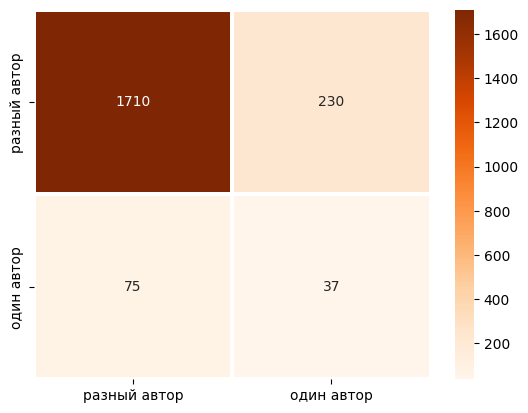

In [58]:
df_cm = DataFrame(cm, index=["разный автор","один автор"], columns=["разный автор","один автор"])
sn.heatmap(df_cm,annot=True, fmt="d",linewidths=1.5,cmap="Oranges",)
plt.savefig("images/authors_words_cnn_confusion_matrix.png",  bbox_inches='tight', pad_inches=0)
plt.show()